In [1]:
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
import os


# Chargement des donnees

In [2]:
clean = '../../datas/CLEAN/E2/'

con = sqlite3.connect(clean + 'E2.db')
df = pd.read_sql('select * from clean_data', con, index_col='index')

con.close()

df[df.columns[:13]].head(1)

,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng,seller_lat,seller_lng,weight,volume
index,,,,,,,,,,,,,
0,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17 00:00:00,-22.975773,-43.192848,-23.542414,-46.490707,125.0,1040.0


# Calcul des delais de livraison et leur exploration

In [3]:
datetime_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)
df.select_dtypes(include=np.datetime64).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104731 entries, 0 to 104730
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_purchase_timestamp       104731 non-null  datetime64[ns]
 1   order_approved_at              104731 non-null  datetime64[ns]
 2   order_delivered_customer_date  104731 non-null  datetime64[ns]
 3   order_estimated_delivery_date  104731 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 4.0 MB


In [4]:
from modules.data_cleaning import get_time_gap
from modules.data_cleaning import apply_zscore

target = get_time_gap(df.order_purchase_timestamp, df.order_delivered_customer_date  )
df.insert(0, 'shipping_delay', target)

temp = get_time_gap(df.order_purchase_timestamp, df.order_estimated_delivery_date)
df.insert(0, 'estimated_delay', temp)

print(df.shape)
df = apply_zscore(df, ['shipping_delay', 'estimated_delay'])
df = df.reset_index(drop=True)
print(df.shape)

(104731, 88)
(101975, 88)


## L'estimation est en retard face à la réalité

En moyenne l'estimation officielle plus importante de 12 jours !

<AxesSubplot:>

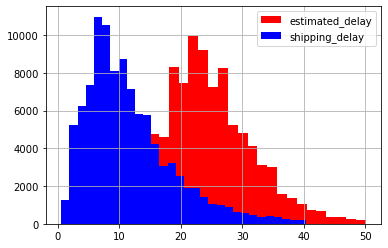

In [5]:
fig = df.estimated_delay.hist(color='red', bins=30, legend=True)
df.shipping_delay.hist(color='blue', bins=30, legend=True)

In [6]:
cols = ['weight', 'volume', 'price', 'freight_value']
print('estimated\n', df[cols].corrwith(df['estimated_delay']))
print('\nshipping_delay\n', df[cols].corrwith(df['shipping_delay']))
print('Correlation entre estimation officielle et realité', df.estimated_delay.corr(df.shipping_delay))

estimated
 weight           0.056929
volume           0.054708
price            0.082396
freight_value    0.362770
dtype: float64

shipping_delay
 weight           0.060127
volume           0.055288
price            0.073157
freight_value    0.300947
dtype: float64
Correlation entre estimation officielle et realité 0.442649684542745


# Extraction de features

### Mois et jour de la semaine

L'information du mois n'est pas equitablement repartie à cause de la periode du jeu de données

Le mois de septembre est le moins représenté 2.5 fois moins que aout

In [7]:
temp = pd.Series([date.month_name() for date in df.order_purchase_timestamp])
df.insert(0, 'month', temp)
px.bar(temp.value_counts().sort_index(), height=300)

In [8]:
temp = pd.Series([date.day_name() for date in df.order_purchase_timestamp])
df.insert(0, 'day_of_week', temp)
px.bar(temp.value_counts().sort_index(), height=300)

In [9]:
date_cols = ['day_of_week', 'month']

encoder = OneHotEncoder(sparse=False)

encoded = pd.DataFrame(
    encoder.fit_transform(df[date_cols])
)

cols = []
for ar in encoder.categories_:
    cols += ar.tolist()
encoded.columns = cols

df = df.drop(columns=date_cols)
df = pd.concat([df, encoded], axis=1)
df.head(1)

,estimated_delay,shipping_delay,order_item_id,price,freight_value,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,...,December,February,January,July,June,March,May,November,October,September
0,28.566238,6.000926,1,21.99,14.11,2017-02-16 10:24:37,2017-02-16 10:35:14,2017-02-22 10:25:57,2017-03-17,-22.975773,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Extraction de la distance en mètres

La distance la plus importante concerne un client en georgie qui commande a un vendeur au bresil.

In [10]:
from modules.data_engineering import get_distance
coord_cols = ['customer_lat', 'customer_lat', 'seller_lat', 'seller_lng']

distances = [   
    get_distance([
        (row.customer_lat, row.customer_lat),
        (row.seller_lat, row.seller_lng),
    ])
    for row
    in df[coord_cols].itertuples()
]
df.insert(0, 'distance', pd.Series(distances))

print(df.shape)
df = apply_zscore(df, ['distance'])
df = df.reset_index(drop=True)
print(df.shape)


(101975, 108)
(99025, 108)


In [11]:
import plotly.express as px

px.histogram(df.distance, height=300)

# Preprocessing

In [12]:
df = df.drop(columns=[
    'order_item_id', 'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_customer_date', 'order_estimated_delivery_date', 
    'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'
], errors='ignore')

y = df.pop('shipping_delay')
y = y.astype('float')

In [13]:
print(df.memory_usage().sum())
numeric_cols = df.select_dtypes(include=np.number).columns

# optimisation de taille
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, downcast="float")
y = y.apply(pd.to_numeric, downcast="float")

print(df.memory_usage().sum())

77635728
38817928


### Feature selection

Si je veux faire un formulaire avec mes données, je souhaite réduire au maximum mon nombre de variables 

( à 20 variables etant donné que les mois et produits sont très simples à renseigner )

La moitié des variables ont en absolu moins de 0.01 de correlation avec le temps de livraison

In [14]:
df.shape[1], (abs(df.corrwith(y)).sort_values(ascending=False) < 0.01).sum()

(98, 49)

65 variables on une P-value inferieures à 0.05

In [37]:
df.shape[1], (pd.Series(f_regression(df, y)[1]).sort_values(ascending=True) < 0.05).sum()

(98, 63)

In [15]:
df_cols = df.columns

selector = SelectKBest(f_regression, k=20)
X = pd.DataFrame(selector.fit_transform(df, y))
X.columns = df_cols[selector.get_support()]
print(X.shape, y.shape)
X.head(1)

(99025, 20) (99025,)


,distance,estimated_delay,price,freight_value,weight,volume,ferramentas_jardim,utilidades_domesticas,moveis_escritorio,Friday,Monday,August,December,February,January,July,June,March,May,November
0,2400.386719,28.566238,21.99,14.11,125.0,1040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='preprocessor_input', con=con, if_exists='replace')
con.close()

### Pipeline

Certaines colonnes sont deja sous forme de OneHotEncoder

C'est pourquoi je ne les traite pas

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('do_nothing', SimpleImputer(strategy='constant', fill_value=-1))
])

categorical_features = X.columns[(~(X.nunique() > 2)).to_list()]
numeric_features = X.columns[(X.nunique() > 2).to_list()]

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

In [34]:
X = pd.DataFrame(preprocessor.fit_transform(X))
X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.449413,0.709033,-0.829501,-0.393858,-0.418558,-0.495045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.008244,-0.083789,3.380557,1.066587,0.587374,0.444592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.008244,-0.083789,3.380557,1.066587,0.587374,0.444592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.094997,-0.690204,3.466915,0.693160,0.073707,-0.039203,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.745247,-0.077396,3.380557,0.909919,0.073707,-0.039203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Sauvegarde du travail

In [35]:
clean = '../../datas/CLEAN/E2/'

if os.path.exists(clean) == False:
    os.makedirs(clean)
con = sqlite3.connect(clean + 'E2.db')
X.to_sql(name='X', con=con, if_exists='replace')
y.to_sql(name='y', con=con, if_exists='replace')
con.close()

In [36]:
from joblib import dump, load
from pathlib import Path

dossier_preprocessor = 'pickle/'
Path(dossier_preprocessor).mkdir(parents=True, exist_ok=True)
dump(preprocessor, dossier_preprocessor + 'preprocessor' + '.pkl')

['pickle/preprocessor.pkl']